<a href="https://colab.research.google.com/github/YuraLeeKr/ML/blob/main/%22KRW_USD_Exchange_Prediction_Prophet_vs_Random_Forest%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**KRW/USD 환율 예측: Prophet vs Ransom Forest**

한국 원화(KRW)와 미국 달러(USD)의 환율 데이터를 기반으로 시계열 모델(Prophe)과 머신러닝 모델(Random Forest)을 비교 분석하여 환율을 예측하고자 한다.


**목차**

- 데이터 전처리 및 시각화
- Prophet을 활용한 환율 예측
- Random Forest를 활용한 환율 예측
- 두 모델의 예측 성능 비교 및 인사이트 도출

In [ ]:
from IPython.display import Markdown

Markdown("""
##사용 데이터 소개

이 프로젝트에서는 2023년 한 해 동안의 **KRW/USD 환율 데이터**와
환율에 영향을 줄 수 있는 **외부 경제 변수 데이터**를 함께 사용했습니다.

---

### 1. 환율 데이터
- 기간: **2023년 1월 ~ 12월**
- 출처: 투자 정보 플랫폼 (Investing.com)
- 주요 컬럼:
  - `date`: 날짜
  - `open`: 시가
  - `high`: 고가
  - `low`: 저가
  - `close`: 종가 (**예측 대상**)
  - `change_pct`: 변동률

---

### 2. 외부 변수 데이터 (External Features)
- 출처: FRED, 한국은행, Yahoo Finance 등
- 변수 목록:
  - **DXY**: 미국 달러 인덱스
  - **interest_diff**: 미국 기준금리 - 한국 기준금리
  - **KOSPI**: 한국 종합주가지수
  - **WTI**: 서부 텍사스산 원유 가격 (국제 유가)

---

### 데이터 구성 목적

- **Prophet 모델**은 시계열 기반으로 `date`와 `close`만을 사용
- **Random Forest 모델**은 환율뿐만 아니라 외부 경제 변수까지 함께 활용하여
  **보다 정교하고 다양한 요인의 영향을 반영한 예측**을 수행할 수 있도록 설계함
""")


##사용 데이터 소개

이 프로젝트에서는 2023년 한 해 동안의 **KRW/USD 환율 데이터**와  
환율에 영향을 줄 수 있는 **외부 경제 변수 데이터**를 함께 사용했습니다.

---

### 1. 환율 데이터
- 기간: **2023년 1월 ~ 12월**
- 출처: 투자 정보 플랫폼 (Investing.com)
- 주요 컬럼:
  - `date`: 날짜
  - `open`: 시가
  - `high`: 고가
  - `low`: 저가
  - `close`: 종가 (**예측 대상**)
  - `change_pct`: 변동률

---

### 2. 외부 변수 데이터 (External Features)
- 출처: FRED, 한국은행, Yahoo Finance 등
- 변수 목록:
  - **DXY**: 미국 달러 인덱스
  - **interest_diff**: 미국 기준금리 - 한국 기준금리
  - **KOSPI**: 한국 종합주가지수
  - **WTI**: 서부 텍사스산 원유 가격 (국제 유가)

---

### 데이터 구성 목적

- **Prophet 모델**은 시계열 기반으로 `date`와 `close`만을 사용
- **Random Forest 모델**은 환율뿐만 아니라 외부 경제 변수까지 함께 활용하여  
  **보다 정교하고 다양한 요인의 영향을 반영한 예측**을 수행할 수 있도록 설계함


**Step0. 라이브러리 불러오기**

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error # 예측 성능 평가 지표
from sklearn.model_selection import train_test_split # 데이터를 훈련용/테스트용으로 나누는 함수

**Step1. 데이터 불러오기 및 전처리**

In [ ]:
df = pd.read_csv('/content/USD_KRW (2023-01~2023-12).csv') # 원본 데이터 읽기

df['날짜'] = df['날짜'].str.replace(' ', '') # 공백 제거
df['날짜'] = pd.to_datetime(df['날짜'], format='%Y-%m-%d') # 문자열 -> datetime으로 자료형 변환

# 쉼표 제거 후 folat형으로 변환
# ex) 1,313.42(문자열 + 쉼표) -> 1313.42(float)
for col in ['종가', '시가', '고가', '저가']:
  df[col] = df[col].str.replace(',', '').astype(float)

# 변동% 컬럼에서 %기호 제거
df['변동 %'] = df['변동 %'].str.replace('%', '').astype(float)

df.sort_values('날짜', inplace=True) # 날짜 오름차순 정렬
df.set_index('날짜', inplace=True) # 날짜를 인덱스로 설정

**Step2. 데이터 시각화**

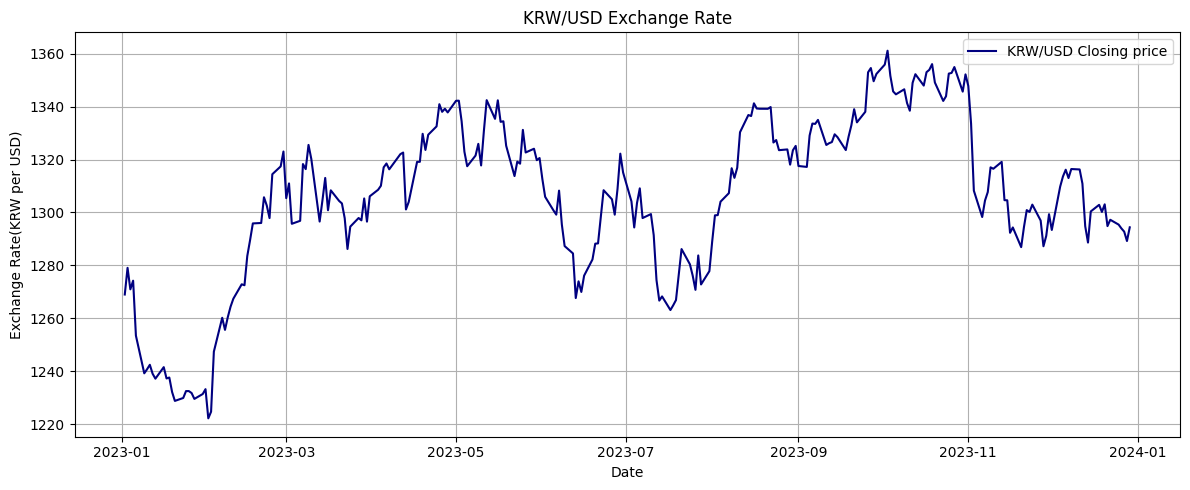

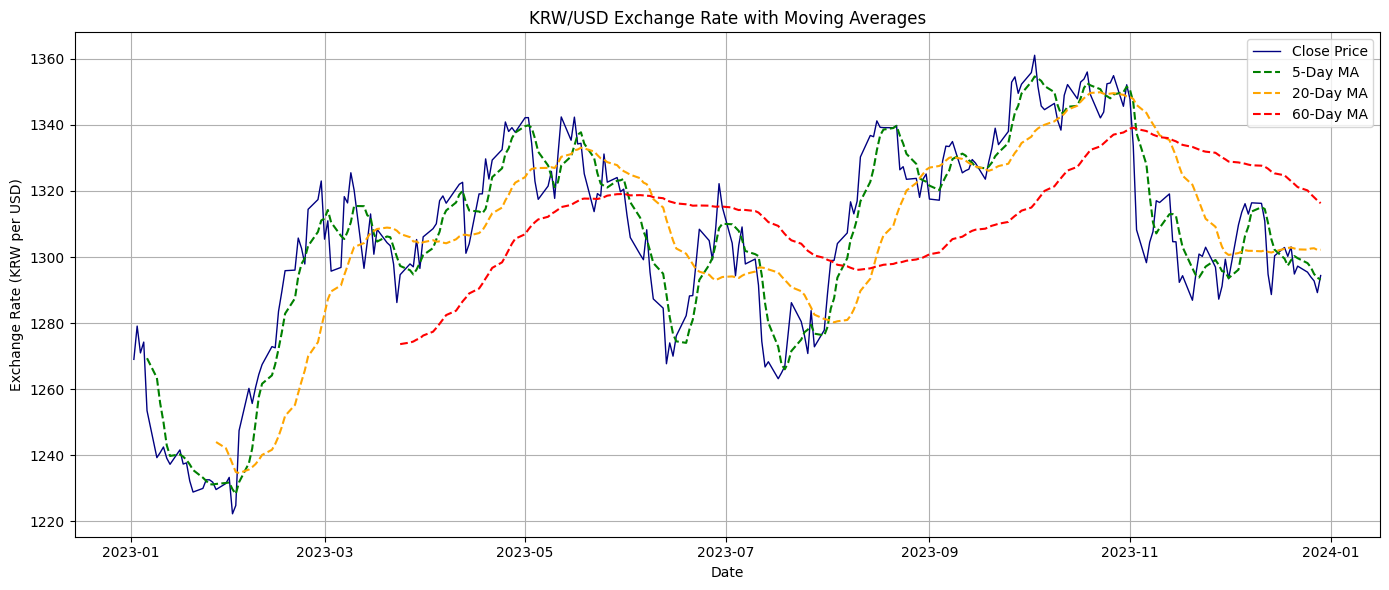

In [ ]:
# 데이터 시각화
plt.figure(figsize=(12, 5)) # 가로 12인치, 세로 5인치
plt.plot(df['종가'], label='KRW/USD Closing price', color='navy') # '종가'를 시간 흐름에 따라 선 그래프로 그
plt.title('KRW/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate(KRW per USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 이동평균선(MA) 계산
df['MA_5'] = df['종가'].rolling(window=5).mean() # 5일 이동평균(단기 추세)
df['MA_20'] = df['종가'].rolling(window=20).mean() # 20일 이동평균(중기 추세)
df['MA_60'] = df['종가'].rolling(window=60).mean() # 60일 이동평균(장기 추)

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(df['종가'], label='Close Price', color='navy', linewidth=1)
plt.plot(df['MA_5'], label='5-Day MA', color='green', linestyle='--')
plt.plot(df['MA_20'], label='20-Day MA', color='orange', linestyle='--')
plt.plot(df['MA_60'], label='60-Day MA', color='red', linestyle='--')
plt.title('KRW/USD Exchange Rate with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (KRW per USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

*Cf) 골든 크로스*

단기 이동평균선이 장기 이동평균선을 아래에서 위로 뚫고 올라가는 현상

->단기 가격이 급상승, 상승 추세로 전환될 가능성

-> 투자자들이 매수 신호로 해석하는 경우 많음

*Cf) 데드 크로스*

단기 이동평균선이 장기 이동 평균선을 위에서 아래로 뚫고 내려가는 현상

-> 단기 가격 하락 -> 하락 추세로 전환될 가능성

-> 많은 투자자들이 매도 신호로 해석

**Step4. Prophet 모델 학습**

In [ ]:
# Prophet 입력 형식에 맞게 ds, y값 형태로 데이터 받
df_prophet = df.reset_index()[['날짜', '종가']].rename(columns={'날짜': 'ds', '종가': 'y'})


# 2024년도 주요 한국 공휴
holidays = pd.DataFrame({
    'holiday': 'Korean_holiday',
    'ds': pd.to_datetime([
        '2024-01-01',  # 신정
        '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', # 설날 연휴
        '2024-03-01',  # 삼일절
        '2024-04-10',   # 제 22대 국회의원 선거
        '2024-05-01',   # 근로자의날
        '2024-05-05',   # 어린이날
        '2024-05-15',  # 부처님오신날
        '2024-06-06',  # 현충일
        '2024-08-15',  # 광복절
        '2024-09-16', '2024-09-17', '2024-09-18',  # 추석
        '2024-10-03',  # 개천절
        '2024-10-09',  # 한글날
        '2024-12-25',  # 크리스마스
    ])
})

# 모델 정의 및 학습
model = Prophet(
    yearly_seasonality = False, # 데이터 셋이 1년동안의 데이터임 -> 1년 단위 패턴은 의미가 없다
    weekly_seasonality = True,
    daily_seasonality = False, #일 단위의 계절성은 환율에 불필요
    holidays = holidays)
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpytacjsdj/28r3r5pe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpytacjsdj/8r701suh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39381', 'data', 'file=/tmp/tmpytacjsdj/28r3r5pe.json', 'init=/tmp/tmpytacjsdj/8r701suh.json', 'output', 'file=/tmp/tmpytacjsdj/prophet_modelhb56aa5q/prophet_model-20250324073810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Step5. Prophet 예측 및 시각화**

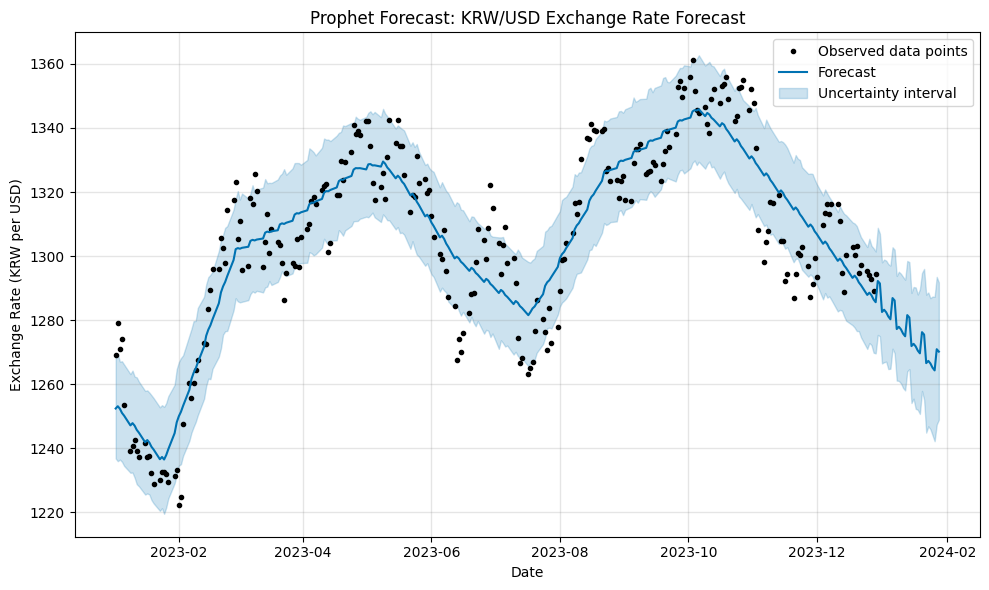

,ds,yhat,yhat_lower,yhat_upper
285,2024-01-24,1266.494784,1245.968535,1286.860245
286,2024-01-25,1265.178185,1244.096291,1287.381396
287,2024-01-26,1264.328748,1242.225753,1287.303637
288,2024-01-27,1270.941361,1247.427165,1293.513063
289,2024-01-28,1270.181164,1248.931434,1291.818102


In [ ]:
# 예측용 데이터프레임 생성 (30일 예측)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# 예측 결과 시각화
fig = model.plot(forecast)
plt.title("Prophet Forecast: KRW/USD Exchange Rate Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate (KRW per USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 예측 요약값 표시
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# yhat: 예측값
# yhat_lower: 예측값의 하한
# yhat_upper: 예측값의 상한

In [ ]:
# 예측 요약 분석 출력
mean_forecast = round(forecast['yhat'][-30:].mean(), 2) # 예측 결과 중 마지막 30일치의 yhat의 평균값 추출
lower_bound = round(forecast['yhat_lower'][-30:].min(), 2) # 예측 결과 중 마지막 30일치 중 가장 낮은 하한값
upper_bound = round(forecast['yhat_upper'][-30:].max(), 2) # 예측 결과 중 마지막 30일치 중 가장 높은 상한

print("[예측 요약]")
print(f"- 평균 예측 환율: {mean_forecast} KRW/USD")
print(f"- 예측 구간: {lower_bound} ~ {upper_bound} KRW/USD (신뢰도 95%)")

[예측 요약]
- 평균 예측 환율: 1276.37 KRW/USD
- 예측 구간: 1242.23 ~ 1308.84 KRW/USD (신뢰도 95%)


**Step6. Random Forest 모델 학습**

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/merged_exchange_with_external_2023_english.csv')

# 입력(X), 정답(y) 설정
X = df[['open', 'high', 'low', 'DXY', 'interest_diff', 'KOSPI', 'WTI']]
y = df['close']

# 학습/테스트 분할 (시간 순서 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# RandomForest 모델 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**Step7. 모델 성능 평가**

1) Prophet 모델 성능 평가

Prophet 예측 결과 비교 (최근 15일)


,Date,Actual,Predicted
0,2023-01-20,1228.86,1298.521987
1,2023-01-19,1232.21,1299.224886
2,2023-01-18,1237.69,1298.423188
3,2023-01-17,1237.34,1297.106589
4,2023-01-16,1241.61,1296.257152
5,2023-01-13,1237.26,1293.200587
6,2023-01-12,1239.12,1293.903486
7,2023-01-11,1242.50,1293.101788
8,2023-01-10,1240.80,1291.785189
9,2023-01-09,1239.28,1290.935751


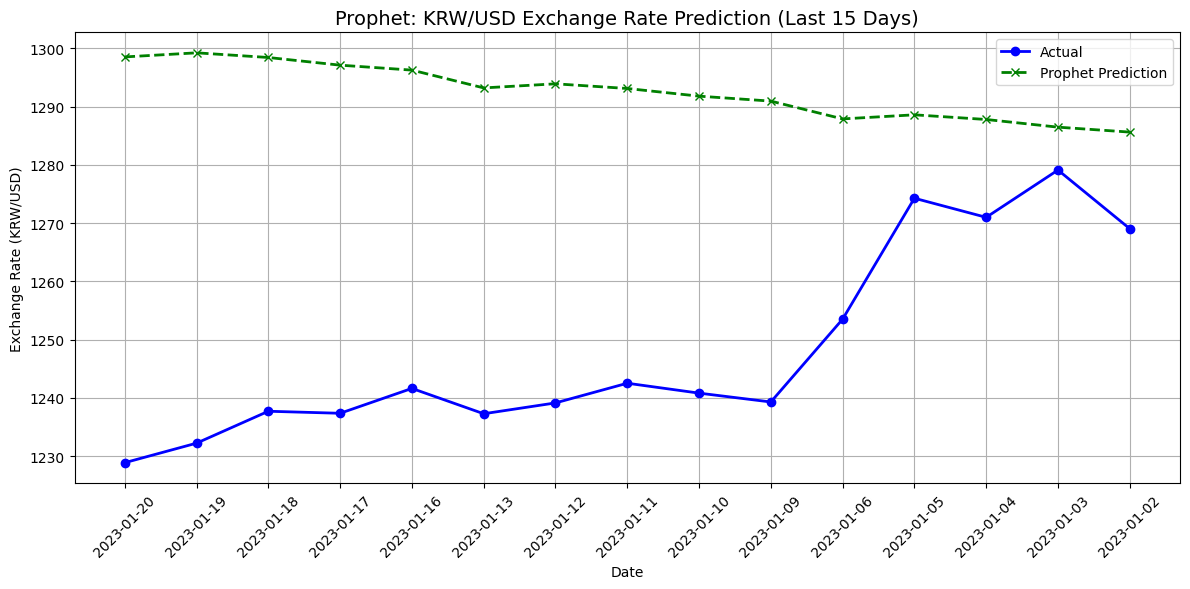

📊 Prophet 성능 평가 (최근 15일 기준)
- MAE: 44.35 KRW
- RMSE: 48.68 KRW


In [ ]:
prophet_df = df[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})
future = model.make_future_dataframe(periods=0)  # 향후 예측 없이 기존 구간 예측
forecast = model.predict(future)

# 실제값과 예측값 준비 (최근 15일)
y_true = prophet_df['y'].iloc[-15:].reset_index(drop=True)
y_pred = forecast['yhat'].iloc[-15:].reset_index(drop=True)
dates = prophet_df['ds'].iloc[-15:].reset_index(drop=True)

# 최근 15일 Prophet 결과 비교 테이블 생성
comparison_prophet_df = pd.DataFrame({
    'Date': prophet_df['ds'].iloc[-15:].values,
    'Actual': prophet_df['y'].iloc[-15:].values,
    'Predicted': forecast['yhat'].iloc[-15:].values
})

# 출력 (원하면 .tail() 등으로 일부만 보기)
print("Prophet 예측 결과 비교 (최근 15일)")
display(comparison_prophet_df)

# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates, y_true, label='Actual', color='blue', marker='o', linewidth=2)
plt.plot(dates, y_pred, label='Prophet Prediction', color='green', linestyle='--', marker='x', linewidth=2)
plt.title('Prophet: KRW/USD Exchange Rate Prediction (Last 15 Days)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Exchange Rate (KRW/USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MAE, RMSE 계산
mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

# 출력
print("📊 Prophet 성능 평가 (최근 15일 기준)")
print(f"- MAE: {mae_prophet:.2f} KRW")
print(f"- RMSE: {rmse_prophet:.2f} KRW")



2) Random Forest 모델 성능 평가

In [ ]:
# 예측
y_pred = rf_model.predict(X_test)

[최근 15일 예측 비교표]


,Date,Actual,Predicted
245,2023-01-20,1228.86,1266.6160
246,2023-01-19,1232.21,1267.1934
247,2023-01-18,1237.69,1266.7217
248,2023-01-17,1237.34,1266.7128
249,2023-01-16,1241.61,1266.7101
250,2023-01-13,1237.26,1268.3770
251,2023-01-12,1239.12,1266.6766
252,2023-01-11,1242.50,1266.9688
253,2023-01-10,1240.80,1266.2277
254,2023-01-09,1239.28,1266.9374


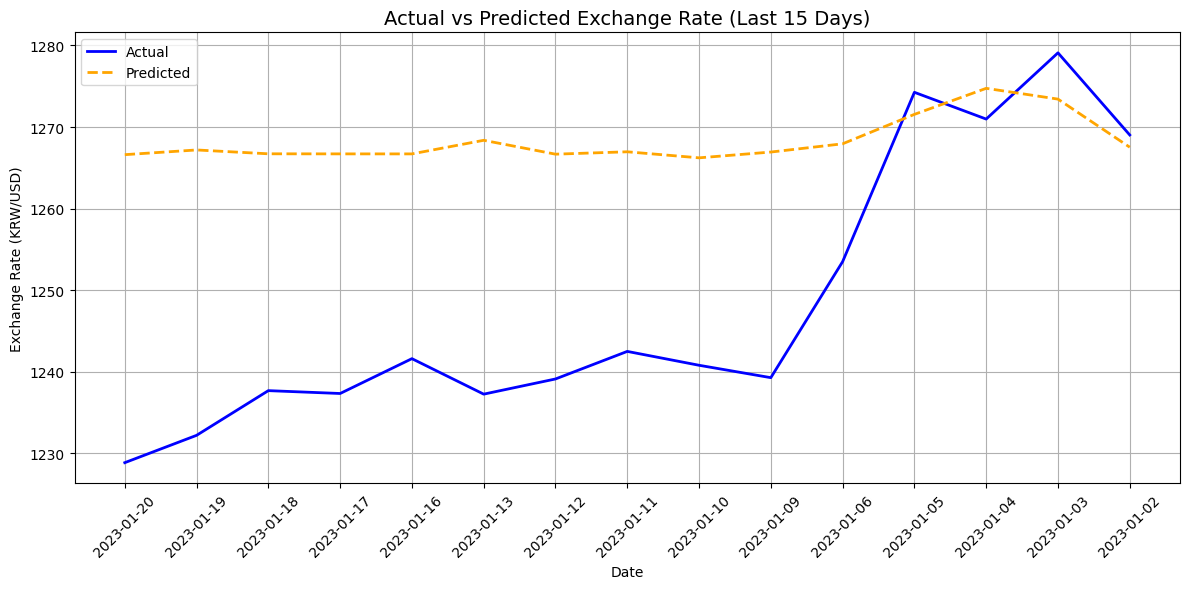

평가 지표
- MAE (Mean Absolute Error): 14.85 → 평균 오차
- RMSE (Root Mean Squared Error): 20.92 → 큰 오차에 민감한 평균


In [ ]:
# 결과 비교 테이블 생성
comparison_df = X_test.copy()
comparison_df['Actual'] = y_test.values
comparison_df['Predicted'] = y_pred
comparison_df['Date'] = df['date'].iloc[-len(y_test):].values

# 최근 15일만 추출
last_15_df = comparison_df[['Date', 'Actual', 'Predicted']].tail(15)

#비교 테이블 출력
print("[최근 15일 예측 비교표]")
display(last_15_df)

#그래프 시각화 (최근 15일)
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'][-15:], comparison_df['Actual'][-15:], label='Actual', color='blue', linewidth=2)
plt.plot(comparison_df['Date'][-15:], comparison_df['Predicted'][-15:], label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Exchange Rate (Last 15 Days)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Exchange Rate (KRW/USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# MAE & RMSE 계산 및 설명 출력
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("평가 지표")
print(f"- MAE (Mean Absolute Error): {mae:.2f} → 평균 오차")
print(f"- RMSE (Root Mean Squared Error): {rmse:.2f} → 큰 오차에 민감한 평균")

**Step9. 결론 및 인사이트 도출**

이 두 모델을 동일한 데이터(2023년 환율 + 외부 변수 기준)로 학습시켜 성능을 비교했다.

In [ ]:
from IPython.display import Markdown

Markdown("""
## Prophet vs Random Forest 성능 비교 (최근 15일 기준)

| 모델             | MAE (↓)         | RMSE (↓)        |
|------------------|------------------|------------------|
| **Prophet**       | **44.35 KRW**   | **48.68 KRW**   |
| **Random Forest** | **14.85 KRW**    | **20.92 KRW**    |

---

### 평가 지표 설명

- **MAE** (Mean Absolute Error):
  예측값과 실제값의 **평균 절대 오차**입니다. 수치가 낮을수록 더 정확한 예측.

- **RMSE** (Root Mean Squared Error):
  제곱 오차의 평균의 제곱근으로, **큰 오차에 민감하게 반응**한다.

---

### 인사이트 요약

- Prophet은 시계열 패턴(추세, 계절성, 공휴일 등)을 반영하지만,
  외부 변수의 영향을 고려하지 못해 예측이 제한적일 수 다.

- Random Forest는 외부 변수(DXY, 금리차, 유가 등)를 활용하여
  경제 상황 변화에 더 유연하게 대응하며, 예측 정확도(MAE)가 더 높게 나왔다.

---

### 결론

- Prophet은 시계열의 패턴(추세, 계절성, 공휴일 등)을 잘 반영하지만,
예측 구간에 외부 충격(금리 변화 등)이 있을 경우 민감하게 반응하지 못함.

- Random Forest는 시계열 특화 모델은 아니지만,
다양한 외부 요인을 포함한 예측이 가능하여
최근 변동이 컸던 기간에는 더 우수한 성능을 보여줌.

-> 실전에서는 **두 모델을 보완적으로 활용하거나 하이브리드 구조**로 통합하는 것이 유리할 수 있음.
""")



## Prophet vs Random Forest 성능 비교 (최근 15일 기준)

| 모델             | MAE (↓)         | RMSE (↓)        |
|------------------|------------------|------------------|
| **Prophet**       | **44.35 KRW**   | **48.68 KRW**   |
| **Random Forest** | **14.85 KRW**    | **20.92 KRW**    |

---

### 평가 지표 설명

- **MAE** (Mean Absolute Error):  
  예측값과 실제값의 **평균 절대 오차**입니다. 수치가 낮을수록 더 정확한 예측.

- **RMSE** (Root Mean Squared Error):  
  제곱 오차의 평균의 제곱근으로, **큰 오차에 민감하게 반응**한다.

---

### 인사이트 요약

- Prophet은 시계열 패턴(추세, 계절성, 공휴일 등)을 반영하지만,  
  외부 변수의 영향을 고려하지 못해 예측이 제한적일 수 다.

- Random Forest는 외부 변수(DXY, 금리차, 유가 등)를 활용하여  
  경제 상황 변화에 더 유연하게 대응하며, 예측 정확도(MAE)가 더 높게 나왔다.

---

### 결론

- Prophet은 시계열의 패턴(추세, 계절성, 공휴일 등)을 잘 반영하지만,
예측 구간에 외부 충격(금리 변화 등)이 있을 경우 민감하게 반응하지 못함.

- Random Forest는 시계열 특화 모델은 아니지만,
다양한 외부 요인을 포함한 예측이 가능하여
최근 변동이 컸던 기간에는 더 우수한 성능을 보여줌.
 
-> 실전에서는 **두 모델을 보완적으로 활용하거나 하이브리드 구조**로 통합하는 것이 유리할 수 있음.
